In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import dateutil as du
import re
import requests
import io
import os
%matplotlib inline  

In [2]:
def get_day(df, dOfWk, val):
    """
    purpose: flatten pandas DataFrame from day to wk level
    input: 
        df - one wk long DataFrame with values of interest by day
        dOfWk - day of week varname
        val - varname of the value we are interested in
    output: DataFrame flattened to one row per wk
    note: see Paul's example code in Slack
    """
    li = []
    for day in range(1, 8):
        item = list(df[df[dOfWk] == day][val])
        if item:
            li += item
        else:
            li += [np.nan]
    return li

In [3]:
def ChooseTurnstile(station):
    #by Walter
    a = turn.loc[turn["STATION"] == station]
    return a

In [4]:
FILENAME = ['turnstile_170408', 'turnstile_170401']
STATION_GROUP = ['C/A', 'UNIT', 'STATION']
        #Our group found duplicated C/A's in one Station. We think STATION > UNIT ? C/A > SCP
TURN_GROUP = STATION_GROUP + ['SCP']

In [5]:
#data import (note: I decided to go with two arbitrary files)
if os.path.isfile('turn_cleaned.csv'):
    turn = pd.read_csv('turn_cleaned.csv', index_col=0)
else:
    turn = pd.DataFrame()
    for fn in FILENAME:
        url = r"http://web.mta.info/developers/data/nyct/turnstile/"+fn+r".txt"
        temp = requests.get(url).content
        temp = pd.read_csv(io.StringIO(temp.decode('utf-8')))
        try:
            turn = turn.append(temp)
        except:
            turn = temp.copy()
            
    #toy dataset
    #turn = turn.head(500).append(turn.tail(500)); 
    #turn.reset_index(inplace=True) 

    #check data
    #turn.shape
    #turn['DATE'].sort_values().value_counts()
    #turn.head(2)
    #turn.tail(2)

    #cleaning and feature engineering
    shape = turn.shape
    turn.columns = turn.columns.str.strip()
    turn.loc[:, 'd'] = turn['DATE'].map(lambda x: pd.to_datetime(x))
    turn.loc[:, 'ts'] = turn['DATE'].str.cat(turn['TIME'], sep = " ").map(lambda x: pd.to_datetime(x))
    turn.loc[:, 'hr'] = turn['ts'].dt.hour
    turn.loc[:, 'wday_ch'] = turn.loc[:, 'd'].map(lambda x: x.strftime("%A"))
    turn.loc[:, 'wday_num'] = turn.loc[:, 'd'].map(lambda x: x.isoweekday())
    turn.loc[:, 'wk'] = turn.loc[:, 'd'].map(lambda x: x.isocalendar()[1])

    ##cols for Benson proj
    #turn['d'].value_counts()
    turn.loc[turn['d'].isin(pd.date_range(dt.datetime(2015, 6, 1), dt.datetime(2015, 8, 1))), 'timeslot'] = "Summer2015"
    turn.loc[turn['d'].isin(pd.date_range(dt.datetime(2015, 9, 1), dt.datetime(2015, 11, 1))), 'timeslot'] = "Fall2015"
    turn.loc[turn['d'].isin(pd.date_range(dt.datetime(2016, 6, 1), dt.datetime(2016, 8, 1))), 'timeslot'] = "Summer2016"
    turn.loc[turn['d'].isin(pd.date_range(dt.datetime(2016, 9, 1), dt.datetime(2016, 11, 1))), 'timeslot'] = "Fall2016"

    turn.sort_values(TURN_GROUP + ['ts'], inplace = True)
    turn.loc[:, 'net_enter'] = turn['ENTRIES'] - turn.groupby(TURN_GROUP)['ENTRIES'].shift(1)
    turn.loc[:, 'net_exits'] = turn['EXITS'] - turn.groupby(TURN_GROUP)['EXITS'].shift(1)
    turn.loc[:, 'tot_traffic'] = turn['net_enter'] + turn['net_exits']
    #turn.loc[:, 'net_traffic'] = turn['net_enter'] - turn['net_exits']

    ##get rid of duplicates and audit
    turn = turn[turn['DESC'] == 'REGULAR']

    ##make counter resets missing
    turn.loc[turn['net_enter'] < 0, 'net_enter'] = np.nan
    turn.loc[turn['net_exits'] < 0, 'net_exits'] = np.nan

    ##make outliers missing (one of the records show a marathon weekend)
    #turn['net_exits'].hist(); turn.loc[turn['net_exits'] > 20000, 'd'].value_counts()
    turn.loc[turn['net_exits'] > 20000, 'net_exits'] = np.nan

    turn.reset_index(inplace = True)
    turn.to_csv('turn_cleaned.csv')

In [12]:
#challenge 1
turn_dic = {}
val_col = ['LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
for row in range(10): #range(shape[0]):
    key = tuple(turn.loc[row, TURN_GROUP])
    val = list(turn.loc[row, val_col])
    try:
        turn_dic[key] += [val]
    except:
        turn_dic[key] = [val]

In [14]:
#turn_dic

In [15]:
#challenge 2
turn_ts = {}
for row in range(10): #range(shape[0]):
    key = tuple(turn.loc[row, TURN_GROUP])
    val = [du.parser.parse(turn['ts'][row]), turn['tot_traffic'][row]]
    try:
        turn_ts[key] += [val]
    except:
        turn_ts[key] = [val]

In [17]:
#turn_ts

In [18]:
#challenge 3
time_obj = turn.loc[:2, 'ts'].map(du.parser.parse)
n = int((time_obj[1] - time_obj[0]).seconds / 3600)
print("These counts are for every", n, "hours.")

These counts are for every 4 hours.


In [19]:
dt_turn_day = turn[TURN_GROUP + ['d', 'tot_traffic']]
dt_turn_day = dt_turn_day.groupby(TURN_GROUP + ['d']).sum()
dt_turn_day.reset_index(inplace=True)
dt_turn_day.loc[dt_turn_day['tot_traffic'].map(math.isnan), 'tot_traffic'] = 0
dt_turn_day['tot_traffic'] = dt_turn_day['tot_traffic'].astype(int)

turn_day = {}
for row in range(100): #range(dt_turn_day.shape[0]):
    key = tuple(dt_turn_day.iloc[row, 0:4])
    val = [du.parser.parse(dt_turn_day['d'][row]).date(), dt_turn_day['tot_traffic'][row]]
    try:
        turn_day[key] += [val]
    except:
        turn_day[key] = [val]

In [21]:
#turn_day

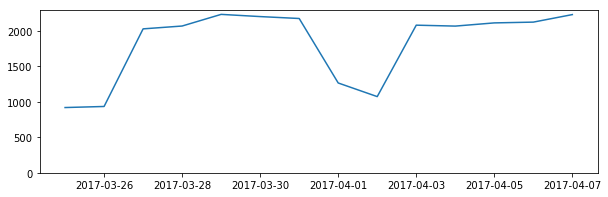

In [22]:
#challenge 4
one_turnstile = list(turn_day.keys())[0] #arbitrary pick
dates = [x[0] for x in turn_day[one_turnstile]]
counts = [x[1] for x in turn_day[one_turnstile]]
     
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.ylim(ymin = 0)
plt.show() #TODO add title and stuff
        
#plt.scatter(turn['d'].map(lambda x: x.isoweekday()), turn['tot_traffic'])
#plt.scatter(turn['hr'], turn['tot_traffic'])

In [23]:
#challenge 5
dt_turn_day_station = turn[STATION_GROUP + ['d', 'tot_traffic']]
dt_turn_day_station = dt_turn_day_station.groupby(STATION_GROUP + ['d']).sum()
dt_turn_day_station.reset_index(inplace=True)
dt_turn_day_station['tot_traffic'] = dt_turn_day_station['tot_traffic'].astype(int)

In [26]:
#dt_turn_day_station.head(2)

,C/A,UNIT,STATION,d,tot_traffic
0,A002,R051,59 ST,2017-03-25 00:00:00,11320
1,A002,R051,59 ST,2017-03-26 00:00:00,10749


In [28]:
#Challenge 6      
turn_day_station = {}
for row in range(dt_turn_day_station.shape[0]):
    key = tuple(dt_turn_day_station[STATION_GROUP].iloc[row])
    val = [du.parser.parse(dt_turn_day_station['d'][row]).date(), dt_turn_day_station['tot_traffic'][row]]
    try:
        turn_day_station[key] += [val]
    except:
        turn_day_station[key] = [val]   

In [30]:
#turn_day_station

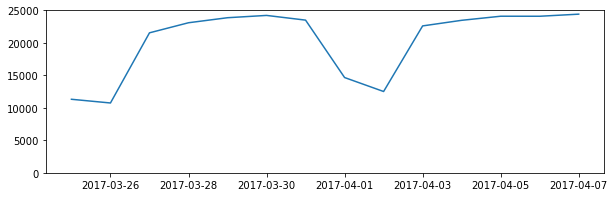

In [31]:
#Challenge 7
one_station = list(turn_day_station.keys())[0]
dates = [x[0] for x in turn_day_station[one_station]]
counts = [x[1] for x in turn_day_station[one_station]]
     
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.ylim(ymin = 0)
plt.show() 

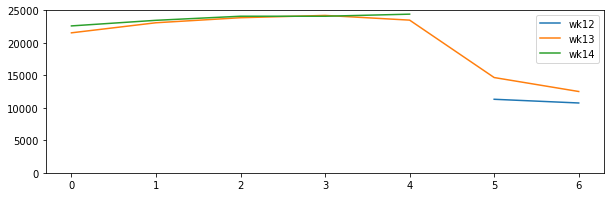

In [32]:
#Challenge 8
dt_turn_wk_station = turn[STATION_GROUP + ['wk', 'wday_num', 'tot_traffic']]
dt_turn_wk_station = dt_turn_wk_station.groupby(STATION_GROUP + ['wk', 'wday_num']).sum()       
dt_turn_wk_station.reset_index(inplace=True)  
gp = STATION_GROUP + ['wk'] 
g = dt_turn_wk_station.groupby(gp)
dt_turn_wk_station = pd.DataFrame(g.apply(lambda x: get_day(x, 'wday_num', 'tot_traffic')))
dt_turn_wk_station.rename(columns = {0: 'tot_traffic'}, inplace = True)  
#alternative method 
#dt_turn_wk_station = dt_turn_wk_station.pivot_table( 
#        values = 'tot_traffic', 
#        index = STATION_GROUP + ['wk'], 
#        columns = ['wday']) 
dt_turn_wk_station.reset_index(inplace=True)               
        
turn_wk_station = {}
    #data structure: (ca, unit, station): [{wk1: [m,t,w,t,f,s,s]}, {wk2: [m,t,w,t,f,s,s]}]
for row in range(dt_turn_wk_station.shape[0]):
    key = tuple(dt_turn_wk_station[STATION_GROUP].iloc[row])
    val_key = dt_turn_wk_station['wk'].iloc[row]
    val_val = dt_turn_wk_station['tot_traffic'].iloc[row]
    val = {val_key: val_val}
    try:
        turn_wk_station[key] += [val]
    except:
        turn_wk_station[key] = [val]
        
dates = [x for x in turn_wk_station[one_station]]
plt.figure(figsize=(10,3))
for li in dates:
    week_count_list = list(li.values())[0]
    lab = list(li.keys())[0]
    plt.plot(week_count_list, label = "wk" + str(lab))   
plt.ylim(ymin = 0)
plt.legend()
plt.show()

In [34]:
#Challenge 9
g = dt_turn_day_station.groupby(STATION_GROUP)
dt_turn_station_avg = pd.DataFrame(g.agg({'tot_traffic': [pd.Series.count, np.sum, pd.Series.mean]}))
dt_turn_station_avg.columns = dt_turn_station_avg.columns.get_level_values(1)
dt_turn_station_avg.reset_index(inplace = True)
dt_turn_station_avg.sort_values('mean', ascending = False, inplace = True)

top_num = 4
print(r"Top " + str(top_num) + " stations with the highest traffic during the time I investigate:", "\n")
dt_turn_station_avg.head(top_num)

Top 4 stations with the highest traffic during the time I investigate: 



,C/A,UNIT,STATION,count,sum,mean
374,N508,R453,23 ST,14,539299083357,3.852136e+10
35,A066,R118,CANAL ST,14,496745522854,3.548182e+10
164,J034,R007,104 ST,14,462801948479,3.305728e+10
214,N063A,R011,42 ST-PORT AUTH,14,421615996857,3.011543e+10


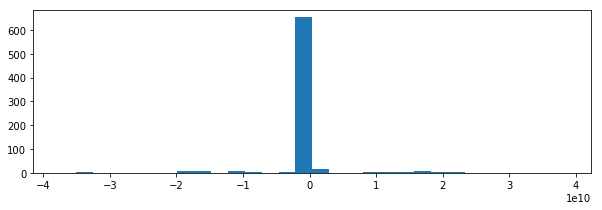

In [38]:
#Challenge 10
total_ridership_counts = list(dt_turn_station_avg["mean"])
plt.figure(figsize=(10,3))
plt.hist(total_ridership_counts, bins = 30)
plt.show()

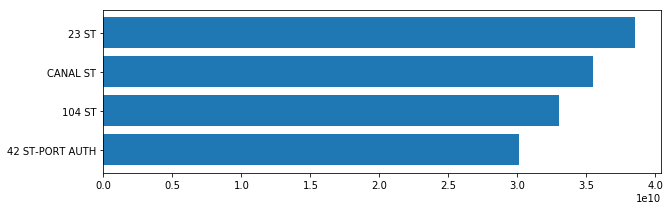

In [42]:
indices = range(len(total_ridership_counts)-1, -1, -1)
plt.figure(figsize=(10,3))
plt.barh(list(indices)[:top_num], total_ridership_counts[:top_num], align='center')
#plt.ylim(ymin = -0.5)
label1 = list(dt_turn_station_avg["STATION"])[:top_num]
plt.yticks(list(indices)[:top_num], label1)
plt.show()